# Homework 8

Due to gradescope April 19 at 11:59pm EST. Please submit an `.ipynb` file.   

Import packages needed for assignment. Make sure to run this cell first or later cells will not run.


In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing, SimpleExpSmoothing

## Problem 1: Optimizing with Logistic Regression. 
To  start, we will practice Logistic Regression on the data set in HW8.csv.
This CSV file contains three column: X,Y,Z. Create 2 models:
-  $P(Z=1|X) = L(β_0 + β_1 X)$
-  $P(Y=1|X) = L(β_0 + β_1 X)$

a. Load in the data to a pandas DataFrame and construct these two models using statsmodels. Report the coefficients of both models. 

In [2]:
# Your code here
df_hw8 = pd.read_csv("HW8.csv")
df_hw8.head()

,Z,Y,X
0,1,1,0.945809
1,1,0,0.597102
2,1,1,0.735095
3,0,1,0.743858
4,1,1,0.898433


In [3]:
X = df_hw8[["X"]]
Y = df_hw8[["Y"]]
Z = df_hw8[["Z"]]
X = sm.add_constant(X)
model_y = sm.Logit(Y, X).fit()
model_z = sm.Logit(Z, X).fit()

Optimization terminated successfully.
         Current function value: 0.466668
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443839
         Iterations 6


C:\Users\bls24\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [4]:
model_y.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      998
Method:                           MLE   Df Model:                            1
Date:                Sun, 18 Apr 2021   Pseudo R-squ.:                0.006823
Time:                        20:11:06   Log-Likelihood:                -466.67
converged:                       True   LL-Null:                       -469.87
Covariance Type:            nonrobust   LLR p-value:                   0.01134
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9019      0.177     10.759      0.000       1.555       2.248
X             -0.7197      0.286     -2.515      0.012      -1.281      -0.159
==============================================================================
"""

In [5]:
model_z.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      Z   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      998
Method:                           MLE   Df Model:                            1
Date:                Sun, 18 Apr 2021   Pseudo R-squ.:                 0.02979
Time:                        20:11:06   Log-Likelihood:                -443.84
converged:                       True   LL-Null:                       -457.47
Covariance Type:            nonrobust   LLR p-value:                 1.781e-07
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8688      0.153      5.693      0.000       0.570       1.168
X              1.5297      0.300      5.103      0.000       0.942       2.117
==============================================================================
"""

Coefficient Y: beta_1 = -0.7197 and beta_0 = 1.9019

Coefficient Z:  beta_1 = 1.5297 and beta_0 = 0.8688

b. Find the predicted $P(Z=1|X)$ when $X=1/2$.

In [6]:
# Your code here
new_x = pd.DataFrame([[1,0.5]])
model_z.predict(new_x)

0    0.836667
dtype: float64

c. Find the value of $X$ that maximizes $P(Z=1|X)$, subject to the constraint that $P(Y=1|X) >= 0.8.$  

To do this randomly generate 1,000,000 search points from a uniform distribution U over the range $-5 <= X <= 5$ and remove all X which do not satisfy the constraint. Use this smaller set to find the $X$ that maximizes $P(Z=1|X)$. 

In [7]:
# Your code here
N = 1000000
search = pd.DataFrame()
search['X'] = np.random.uniform(-5,5,N)
x_val = sm.add_constant(search['X'])
search['prob_y'] = model_y.predict(x_val)
search['prob_z'] = model_z.predict(x_val)
filtered_set = search[search['prob_y'] >= 0.8]

In [8]:
max_value = filtered_set[filtered_set['prob_z'] == filtered_set['prob_z'].max()]
max_value

,X,prob_y,prob_z
782942,0.716403,0.800001,0.877037


## Problem 2: Evaluating Classifiers
Logistic regression is an example of a "classifier" --- a machine learning method for predicting binary outcomes (also called "classes") associated with a set of predictors. In this problem, we will learn about ROC curves, which are a better way to evaluate classifiers in some applications than the log-likelihood that you have already learned.

We will use data from Kaggle on precipitation in Australia. This dataset originated at https://www.kaggle.com/jsphyg/weather-dataset-rattle-package and is available on the website.

a. First, load in the Dataset `WeatherAUS.csv` from the web and display the first 5 rows. Use the pandas command `df.describe()` to display summary statistics such as the mean for each column. 

In [9]:
#Your code here
df_weather = pd.read_csv('weatherAUS.csv')
df_weather.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [10]:
df_weather.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RISK_MM
count,141556.000000,141871.000000,140787.000000,81350.000000,74377.000000,132923.000000,140845.000000,139563.000000,140419.000000,138583.000000,128179.000000,128212.000000,88536.000000,85099.000000,141289.000000,139467.000000,142193.000000
mean,12.186400,23.226784,2.349974,5.469824,7.624853,39.984292,14.001988,18.637576,68.843810,51.482606,1017.653758,1015.258204,4.437189,4.503167,16.987509,21.687235,2.360682
std,6.403283,7.117618,8.465173,4.188537,3.781525,13.588801,8.893337,8.803345,19.051293,20.797772,7.105476,7.036677,2.887016,2.720633,6.492838,6.937594,8.477969
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,0.000000
25%,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000,0.000000
50%,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,0.000000
75%,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000,0.800000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000,371.000000


b. This dataset contains non-numerical columns. For now, filter your data so that you have the following columns:

'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am',
'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm',
'Temp9am', 'Temp3pm', 'RainToday', and 'RainTomorrow'

After doing so, remove all data points with empty or NA in any field.
The pandas function dropna() to be very useful for this.

Documentation: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html


In [11]:
#Your code here
df_weather_new = df_weather[['MinTemp','MaxTemp',  'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow'] ]
df_weather_new = df_weather_new.dropna()

c. Before we construct the model, the columns `RainToday` and `RainTomorrow` must be converted to integers.

Look through the documentation for pandas function replace(). Use it to replace the strings 'Yes' and 'No' with integers 1 and 0 respectively in the `RainToday` and `RainTomorrow` columns. 
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html


In [12]:
#Your code here
df_weather_new['RainToday'] = df_weather_new['RainToday'].replace('Yes', 1).replace('No', 0)
df_weather_new['RainTomorrow'] = df_weather_new['RainTomorrow'].replace('Yes', 1).replace('No', 0)
df_weather_new.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,13.4,22.9,0.6,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,0,0
1,7.4,25.1,0.0,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,0,0
2,12.9,25.7,0.0,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,0,0
3,9.2,28.0,0.0,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,0,0
4,17.5,32.3,1.0,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,0,0


d. Now we can create our model. 
Set up a model that predicts whether it will rain tomorrow using the remaining predictors from your dataframe and an intercept (added using sm.add_constant).

Use train_test_split() to hold out a subset of the data for model evaluation. Hold out 30\% for the test set and to make things consistent, use the random state of 100. Then build and fit your logistic regression model.

Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [13]:
#Your code here
X = df_weather_new.loc[:,df_weather_new.columns!='RainTomorrow']
Y = df_weather_new['RainTomorrow']
X = sm.add_constant(X)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3, random_state=100)
model_weather = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.351592
         Iterations 7


e. Often we are in a situation where we need to make binary predictions (i.e., predictions that are either 0 or 1) for new data based on our logistic regression. To go from the probabilities provided by logistic regression to binary predictions, we choose a threshold, predict a 1 when our probability is above the threshold and a 0 when it is below. Below we call this threshold the "classification threshold".

Using a classification threshold of 0.5, calculate predictions for each row in the test data. Provide this as a series of boolean or integer values where True or 1 indicates that we are predicting it will rain tomorrow, and False or 0 indicates we are predicting it won't rain. Save this output as `predictions` for later.

0.5 is often the default classification threshold used in the real world when we want to convert probabilities to binary classifications.

In [15]:
x_test_predictions = []
for i in model_weather.predict(X_test):
    if i >= 0.5:
        x_test_predictions.append(1)
    else:
        x_test_predictions.append(0)
x_test_predictions = np.array(x_test_predictions)

f. Using `predictions` from the previous cell, we will compute four numbers that are used to assess a classifier:
* True Positives: # rows in the test data where RainTomorrow was true and we correctly predicted this
* True Negatives: # rows in the test data where RainTomorrow was false and we correctly predicted this
* False Positives: # rows in the test data where RainTomorrow was false but we incorrectly predicted it would be true
* False Negatives: # rows in the test data where RainTomorrow was true but we incorrectly predicted it would be false

Write code that calculates these four numbers. When arranged into a 2x2 matrix, these four numbers together constitute what is called a "confusion matrix". See, e.g., https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/

How many True negatives? How many True Positives? How many False Positives? How many False Negatives?

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html


Ans: See code below

In [26]:
#Your code here
value_comparison = pd.DataFrame()
value_comparison["prediction"] = pd.Series(x_test_predictions)
value_comparison['true values'] = y_test.values
value_comparison.head()

,prediction,true values
0,0,0
1,0,0
2,0,0
3,1,1
4,0,0


In [41]:
true_positives = 0
true_negatives = 0
false_positives = 0
false_negatives = 0

for index, row in value_comparison.iterrows():
    if row[0] == 0 and row[1] == 0:
        true_negatives+=1
    elif row[0] == 1 and row[1] == 1:
        true_positives+=1
    elif row[0] == 0 and row[1] == 1:
        false_negatives+=1
    elif row[0] == 1 and row[1] == 0:
        false_positives+=1

In [53]:
import sklearn.metrics as skl
print(skl.confusion_matrix(value_comparison['true values'], value_comparison["prediction"] ))
print(true_negatives, false_positives, false_negatives, true_positives)

[[26628  1408]
 [ 3936  3905]]
26628 1408 3936 3905


g. In real-world applications, we might worry differently false positives compared with false negatives. For example, if we are classifying emails as 'Spam' (positive) or 'Not Spam' (negative), we may be more worried about an important email getting sent to our spam folder than we are about a few spam emails getting into our inbox. This causes false positives (a non-spam email incorrectly labeled as spam) to be more costly than false negatives (a spam email incorrectly labeled as non-spam). 

We can account for this by adjusting the classification threshold.

We will consider classification thresholds in this list:
`[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1].`  

For each of these classification thresholds, compute two numbers:
* False Positive Rate (FPR) = $\frac{False Positives}{False Positives + True Negatives}$
* True Positive Rate (TPR) = $\frac{True Positives}{True Positives + False Negatives}$

(This can be simplified by noting that False Positives + True Negatives is just the number of negatives in the data, and True Positives + False Negatives is the number of positives.)

Then plot the TPR on the y-axis versus the FPR on the x-axis as we vary the classification threshold. This is known as a ROC curve. ROC stands for "receiver operating characteristic" https://en.wikipedia.org/wiki/Receiver_operating_characteristic, terminology that dates to their development for understanding radar signals during World War II.

In [57]:
#Your code here
thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
FPR = []
TPR = []

for i in range(len(thresholds)):
    pred = model_weather.predict(sm.add_constant(X_test))
    pred[pred>thresholds[i]] = 1
    pred[pred<=thresholds[i]] = 0
    
    matrix = skl.confusion_matrix(y_test, pred)
    FPR.append(matrix[0][1] / (matrix[0][1]+matrix[0][0]))
    TPR.append(matrix[1][1] / (matrix[1][0]+matrix[1][1]))

Text(0, 0.5, 'TPR Value')

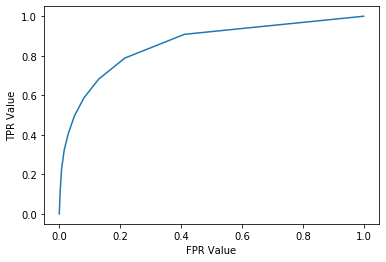

In [76]:
plt.plot(FPR, TPR)
plt.xlabel("FPR Value")
plt.ylabel("TPR Value")

h. What would the ROC curve look like for a perfect classification model? That is a model that correctly predicts whether it rains or not for every entry in the test set.

What do you think the ROC curve would look like for a completely random model? That is a model that returns a probability of raining that is uniformly distributed between 0 and 1 on every day, independent of any of the other features?

Ans: 

a) In this case, for all thresholds over 0.5, the TPR would be equal to 1 at each value since the model correctly predicts every positive. Further, the FPR would be equal to 0 at each value as well, since there are no false positives. 

b) This model would likely have as many true positives as it has false positives, thus the ROC curve might look like a line along y=x of the graph.

# Problem 3

a. Load `2017-nyc-for-hire-vehicles.csv` into a dataframe. (This data came from the NYC Taxi dataset, via https://bigquery.cloud.google.com/dataset/bigquery-public-data:new_york)

Print out a few of the records.  Convert the `date` column to a datetime object using the pd.to_datetime() function.

This dataset contains the number of trips conducted by "for-hire vehicles" (this includes Uber trips, but not yellow or green cabs) in 2017 in New York City. The data is disaggregated by the hour and date of the pickup.

In [77]:
# Your code here
df_problem3 = pd.read_csv('2017-nyc-for-hire-vehicles.csv')
df_problem3.head()

,date,trips
0,2017-01-01 00:00:00,33003
1,2017-01-01 01:00:00,42481
2,2017-01-01 02:00:00,40476
3,2017-01-01 03:00:00,34961
4,2017-01-01 04:00:00,25262


b. Plot trips versus date for the week of dates >= 2017-02-1 and < 2017-02-08.
Then, on the same figure, plot trips versus date - 7 days for the trips that happened in the following week (>= 2017-02-08, < 2017-02-15). By subtracting 7 days from the date, you should see two lines that are superimposed.

To subtract 7 days from a date, subtract `datetime.timedelta(days=7)`.

In [117]:
# Your code here
start_date = pd.datetime(2017, 2, 1)
end_date = pd.datetime(2017, 2, 8)
plot_data = pd.DataFrame()
plot_dates = []
plot_trips = []

for index, row in df_problem3.iterrows():
    if row['date'] >= start_date and row['date'] < end_date:
        plot_dates.append(row['date'])
        plot_trips.append(row['trips'])
        
plot_data['date'] = plot_dates
plot_data['trips'] = plot_trips
plot_data = plot_data.reset_index()
plot_data.head()

,index,date,trips
0,0,2017-02-01 00:00:00,10156
1,1,2017-02-01 01:00:00,6114
2,2,2017-02-01 02:00:00,4138
3,3,2017-02-01 03:00:00,3266
4,4,2017-02-01 04:00:00,4336


In [118]:
start_date = pd.datetime(2017, 2, 8)
end_date = pd.datetime(2017, 2, 15)
plot_data2 = pd.DataFrame()
plot_dates2 = []
plot_trips2 = []

for index, row in df_problem3.iterrows():
    if row['date'] >= start_date and row['date'] < end_date:
        plot_dates2.append(row['date'])
        plot_trips2.append(row['trips'])
        
plot_data2['date'] = plot_dates2
plot_data2['trips'] = plot_trips2
plot_data2 = plot_data2.reset_index()
plot_data2.head()

,index,date,trips
0,0,2017-02-08 00:00:00,10321
1,1,2017-02-08 01:00:00,6199
2,2,2017-02-08 02:00:00,4490
3,3,2017-02-08 03:00:00,3805
4,4,2017-02-08 04:00:00,4795


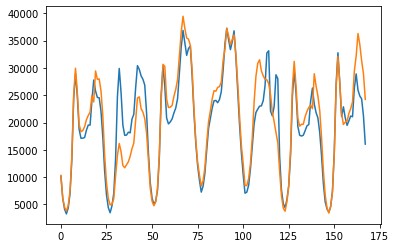

In [119]:
plt.plot(plot_data['index'], plot_data['trips'])
plt.plot(plot_data2['index'], plot_data2['trips'])
#QUESTION -- is this cool to map with the indexes?

c. Split the data into a training set and a test set. Have the first two months of the year be in the training set and the rest be in the test set.  When we split data into training and test for forecasting, we constract each dataset to contain contiguous data.

In [132]:
# Your code here
train_set = pd.DataFrame()
test_set = pd.DataFrame()
X_train = []
X_test = []
y_train = []
y_test = []


for index, row in df_problem3.iterrows():
    if row['date'].month == 1 or row['date'].month == 2:
        X_train.append(row['date'])
        y_train.append(row['trips'])
    else:
        X_test.append(row['date'])
        y_test.append(row['trips'])

train_set['X'] = X_train
train_set['y'] = y_train
test_set['X'] = X_test
test_set['y'] = y_test

In [145]:
train_set = train_set.set_index('X')

In [146]:
test_set = test_set.set_index('X')

d. Fit simple exponential smoothing to the training data. Then, use it to predict values on the test data. Plot the following things over dates from Feb 15 to March 15:
* The original data, in blue
* The fitted values on the dates in the training data, in red
* The forecasted values on the dates in the test data, in black

Also output the sum of squared errors. You can get this via `fit.sse` if fit the return value from `SimpleExpSmoothing().fit()`

In [185]:
# Your code here
model_simple_exp_smoothing = SimpleExpSmoothing(train_set.astype(np.double)).fit()
model_simple_exp_smoothing.sse

C:\Users\bls24\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


19025761047.0

In [148]:
start_date = pd.datetime(2017, 2, 15)
end_date = pd.datetime(2017, 2, 15)
plot_x = []
plot_y = []
first_x = []
second_x = []

for index, row in df_problem3.iterrows():
    if row['date'].month == 2 and row['date'].day >= 15:
        plot_x.append(row['date'])
        plot_y.append(row['trips'])
        first_x.append(row['date'])
    elif row['date'].month == 3 and row['date'].day <= 15:
        plot_x.append(row['date'])
        plot_y.append(row['trips'])
        second_x.append(row['date'])

In [162]:
cutoff = pd.datetime(2017, 2, 15)
fitted_y = model_simple_exp_smoothing.fittedvalues[model_simple_exp_smoothing.fittedvalues.index >= cutoff]

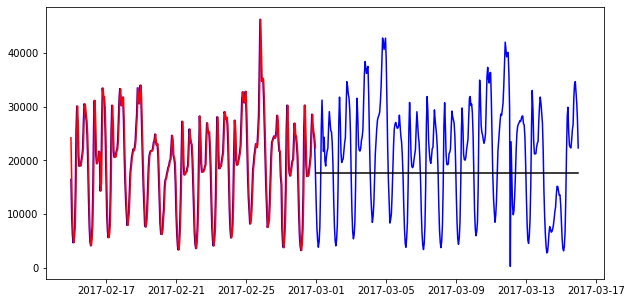

In [171]:
plt.figure(figsize=(10,5))
plt.plot(plot_x,plot_y, color = 'blue')
plt.plot(first_x,fitted_y, color='red')
plt.plot(second_x, model_simple_exp_smoothing.forecast(360) , color = 'black')

e. Repeat question d above for the following model:
* Holt-Winters (ExponentialSmoothing) using additive seasonality and no trend

(You may get a warning that "ConvergenceWarning: Optimization failed to converge. Check mle_retvals."  This has to do with some checks in the code being unsure whether the optimization algorithm that minimizes the sum of squared errors has worked properly. You can ignore this error message in this question.)

Set your inputs to Holt-Winters so that seasonality is assumed to occur over 1 week.

Which model is better and why?

**The Holt-Winters model is better because the sum of squared errors for this model is significantly lower than that of the Simple Exponential Smoothing method**

In [220]:
# Your code and explanation here
model_exp_smoothing = ExponentialSmoothing(train_set.astype(np.double), seasonal='add', seasonal_periods=168).fit()
model_exp_smoothing.sse

C:\Users\bls24\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\bls24\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


4327242822.427474

In [221]:
cutoff = pd.datetime(2017, 2, 15)
fitted_y = model_exp_smoothing.fittedvalues[model_exp_smoothing.fittedvalues.index >= cutoff]

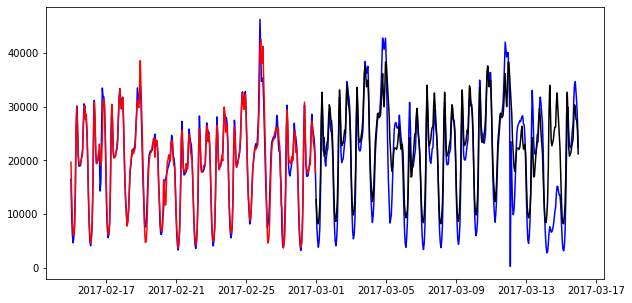

In [222]:
plt.figure(figsize=(10,5))
plt.plot(plot_x,plot_y, color = 'blue')
plt.plot(first_x,fitted_y, color='red')
plt.plot(second_x, model_exp_smoothing.forecast(360) , color = 'black')